In [ ]:
!pip install pyspark cassandra-driver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 17.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PRE_DIR = '/content/drive/MyDrive/BigData/Data'

In [ ]:
from google.colab import files
uploaded = files.upload()  # Chọn file secure-connect-bundle.zip

Saving secure-connect-moocassandra.zip to secure-connect-moocassandra.zip


In [ ]:
import json
with open('/content/MOOCASSANDRA-token.json') as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]
ASTRA_SECURE_BUNDLE_PATH = list(uploaded.keys())[0]
KEYSPACE_NAME = "BIG_MOOC"

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AstraDB-Spark-Integration") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.1") \
    .getOrCreate()
spark.sparkContext.addFile(ASTRA_SECURE_BUNDLE_PATH)
spark.conf.set("spark.cassandra.connection.config.cloud.path", ASTRA_SECURE_BUNDLE_PATH)
spark.conf.set("spark.cassandra.auth.username", CLIENT_ID)
spark.conf.set("spark.cassandra.auth.password", CLIENT_SECRET)

In [ ]:
from pyspark.sql.functions import col, when, count, lit, count
import shutil
import glob
import os
from pyspark.sql.functions import explode, col
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import count, countDistinct

def check_na(spark_df):
    df = spark_df.select([when((col(c) == '') | (col(c) == '[]'), None).otherwise(col(c)).alias(c) for c in spark_df.columns])
    na_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    return na_counts

def check_duplicates(df):
    duplicate_rows = df.groupBy(df.columns).agg(count("*").alias("count")).filter("count > 1")
    return duplicate_rows

def save_df_as_text(df, output_path, file_name):
    temp_output_path = f"{output_path}/_temp_output"
    if os.path.exists(temp_output_path):
        shutil.rmtree(temp_output_path)
    df.coalesce(1).rdd \
        .map(lambda row: "\t".join([str(c) for c in row])) \
        .saveAsTextFile(temp_output_path)
    part_files = glob.glob(f"{temp_output_path}/part-*")
    if part_files:
        part_file = part_files[0]
        final_path = os.path.join(output_path, file_name)
        if os.path.exists(final_path):
            os.remove(final_path)
        shutil.move(part_file, final_path)
        print(f"File saved as {final_path}")
    shutil.rmtree(temp_output_path)

# Courses


In [ ]:
try:
    courses_df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="courses", keyspace="BIG_MOOC") \
        .load()
    courses_df.show(5)
    courses_df.printSchema()
    courses_df.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+---------+----------------------------------------+--------------------+-----+--------------------+--------------------+
|course_id|                                   about|            about_vn|field|                name|             name_vn|
+---------+----------------------------------------+--------------------+-----+--------------------+--------------------+
| C_735130|   大学计算机基础与应用课程作为非计算...|khóa học cơ bản v...|   []|大学计算机基础与应用|những điều cơ bản...|
| C_948252|   中药药剂学是以中医药理论为基础，运...|dược phẩm y học c...|   []|          中药药剂学|dược phẩm y học t...|
| C_696732|   《微波技术与天线》是电子信息、通信...|"công nghệ lò vi ...|   []|      微波技术与天线|công nghệ lò vi s...|
| C_681721|   生命的头三年是发展最为快速的阶段，...|ba năm đầu đời là...|   []|      亲子创意游戏多|nhiều trò chơi sá...|
| C_682193|电子政务，无远弗届；政民互动，如影随形。|chính phủ điện tử...|   []|            电子政务|   chính phủ điện tử|
+---------+----------------------------------------+--------------------+-----+--------------------+--------------------+
only showing top 5 rows

In [ ]:
check_na(courses_df).show()

+---------+-----+--------+-----+----+-------+
|course_id|about|about_vn|field|name|name_vn|
+---------+-----+--------+-----+----+-------+
|        0|    0|       1| 2386|   0|      0|
+---------+-----+--------+-----+----+-------+



## Course-field


In [ ]:
try:
    course_field = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="course_field", keyspace="BIG_MOOC") \
        .load()
    course_field.show(5)
    course_field.printSchema()
    course_field.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+---------+--------------------+
|course_id|               field|
+---------+--------------------+
|   681880|['giáo dục thể ch...|
|   696826| ['kỹ thuật cơ khí']|
|   682554|        ['toán học']|
|   674926|          ['tâm lý']|
|   696821|        ['giáo dục']|
+---------+--------------------+
only showing top 5 rows

root
 |-- course_id: string (nullable = false)
 |-- field: string (nullable = true)

+-------+-----------------+--------------------+
|summary|        course_id|               field|
+-------+-----------------+--------------------+
|  count|              632|                 632|
|   mean|691117.9841772151|                NULL|
| stddev|84019.27745722394|                NULL|
|    min|          1749733|['bảo vệ thực vật...|
|    max|           901947|      ['địa vật lý']|
+-------+-----------------+--------------------+



In [ ]:
from pyspark.sql.functions import concat, lit, col

course_field = course_field.withColumn(
    "course_id",
    concat(lit("C_"), col("course_id"))
)

In [ ]:
from pyspark.sql.functions import col, explode, from_json, collect_list, collect_set
from pyspark.sql.types import ArrayType, StringType

parsed_course_field = course_field.withColumn("field", from_json(col("field"), ArrayType(StringType())))
parsed_courses_df = courses_df.withColumn("field", from_json(col("field"), ArrayType(StringType())))
der_cf_df = parsed_course_field.select(
    col("course_id"),
    explode("field").alias("field")
)
ori_cf_df = parsed_courses_df.select(
    col("course_id"),
    explode("field").alias("field")
)

combined_df = der_cf_df.unionByName(ori_cf_df)

course_field_filter = combined_df.dropna().dropDuplicates() \
    .filter(col("course_id").isin(courses_df.select("course_id").distinct().rdd.flatMap(lambda x: x).collect()))
course_field_filter.show(5)
course_field_filter.describe().show()

+---------+--------------------+
|course_id|               field|
+---------+--------------------+
| C_707054|kỹ thuật hóa học ...|
| C_682217|             lịch sử|
| C_681655|      y học lâm sàng|
| C_696816|        y học cơ bản|
| C_680777|nghiên cứu nghệ t...|
+---------+--------------------+
only showing top 5 rows

+-------+---------+---------------+
|summary|course_id|          field|
+-------+---------+---------------+
|  count|      560|            560|
|   mean|     NULL|           NULL|
| stddev|     NULL|           NULL|
|    min|C_1766899|bảo vệ thực vật|
|    max| C_901947|     địa vật lý|
+-------+---------+---------------+



In [ ]:
course_field_filter.select(
    count("*").alias("total_rows"),
    countDistinct("course_id").alias("unique_courses"),
    countDistinct("field").alias("unique_field")
).show()

+----------+--------------+------------+
|total_rows|unique_courses|unique_field|
+----------+--------------+------------+
|       560|           442|          79|
+----------+--------------+------------+



Lưu file quan hệ course_field_filtered

In [ ]:
save_df_as_text(course_field_filter, PRE_DIR, "course_field_filter.txt")

File saved as /content/drive/MyDrive/BigData/Data/course_field_filter.txt


### Mục mới

In [ ]:
#gộp các field lại theo course_id
join_cf_df = combined_df.dropna().dropDuplicates() \
    .groupBy("course_id") \
    .agg(collect_set("field").alias("field")) \
    .orderBy("course_id")
join_cf_df.show(truncate=False)
join_cf_df.describe().show()

+---------+-------------------------------------------------------+
|course_id|field                                                  |
+---------+-------------------------------------------------------+
|C_1749733|[toán học, khoa học và công nghệ máy tính]             |
|C_1766899|[vật lý]                                               |
|C_1814513|[kinh tế ứng dụng]                                     |
|C_584313 |[lịch sử, ngôn ngữ và văn học trung quốc]              |
|C_584329 |[kinh tế lý thuyết, kinh tế ứng dụng, vật lý, toán học]|
|C_584381 |[truyền thông báo chí, nghiên cứu nghệ thuật]          |
|C_597159 |[khoa học và công nghệ máy tính]                       |
|C_597208 |[khoa học và công nghệ máy tính]                       |
|C_597211 |[khoa học và công nghệ máy tính]                       |
|C_597214 |[khoa học và công nghệ máy tính]                       |
|C_597220 |[khoa học và công nghệ máy tính]                       |
|C_597229 |[khoa học và kỹ thuật quản lý, kinh t

In [ ]:
courses_df = courses_df.drop("field") \
    .join(join_cf_df, on="course_id", how="left")
courses_df.show()

+---------+-------------------------------------+--------------------+---------------------------------+--------------------+--------------------+
|course_id|                                about|            about_vn|                             name|             name_vn|               field|
+---------+-------------------------------------+--------------------+---------------------------------+--------------------+--------------------+
| C_948402|任正非最大的烦恼不是品牌销量，竟是...|rắc rối lớn nhất ...|                   信息理论与编码|lý thuyết thông t...|                NULL|
| C_681730|《中医老年病学》是应用中医理论研究...|"lão khoa của y h...|                     中医老年病学|lão khoa trong y ...|[y học lâm sàng, ...|
| C_947235|为学习者建立人与自然的文明观，从一...|thiết lập quan đi...|                     生态文明讲论|văn minh sinh thá...|                NULL|
|C_1776287|你知道纯牛奶在纸盒里面能常温保存六...|bạn biết gì là bí...|                      包装材料学B| vật liệu đóng gói b|                NULL|
| C_681345|课程面向三维设计初学者，帮助你快速...|khóa học nhằm mục...|          

### Thống kê

Số lượng fields của các khóa học

In [ ]:
from pyspark.sql.functions import size

len_df = courses_df.select("course_id", size("field").alias("len")) \
                  .orderBy("len", ascending=False)

len_df.show(10)

+---------+---+
|course_id|len|
+---------+---+
| C_696753|  7|
| C_682313|  4|
| C_707369|  3|
| C_681730|  3|
| C_682637|  3|
| C_735378|  3|
| C_676663|  3|
| C_747044|  3|
| C_696659|  3|
| C_676658|  3|
+---------+---+
only showing top 10 rows



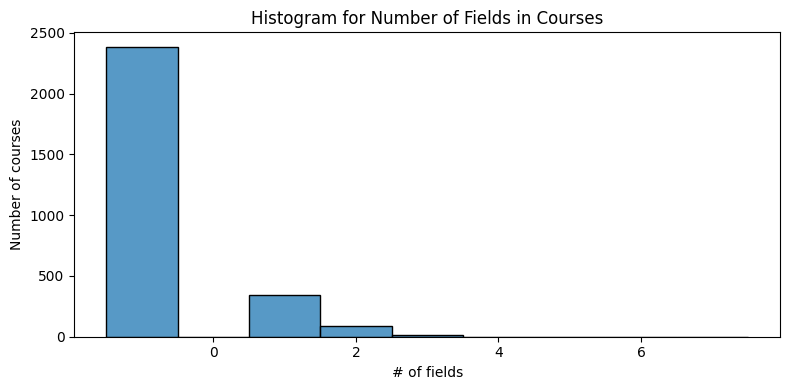

In [ ]:
len_pd = len_df.toPandas()
plt.figure(figsize=(8, 4))
sns.histplot(len_pd, x='len', bins=range(0, len_pd['len'].max() + 2), discrete=True)
plt.title('Histogram for Number of Fields in Courses')
plt.xlabel('# of fields')
plt.ylabel('Number of courses')
plt.tight_layout()
plt.show()

Số lượng khoá học thuộc field

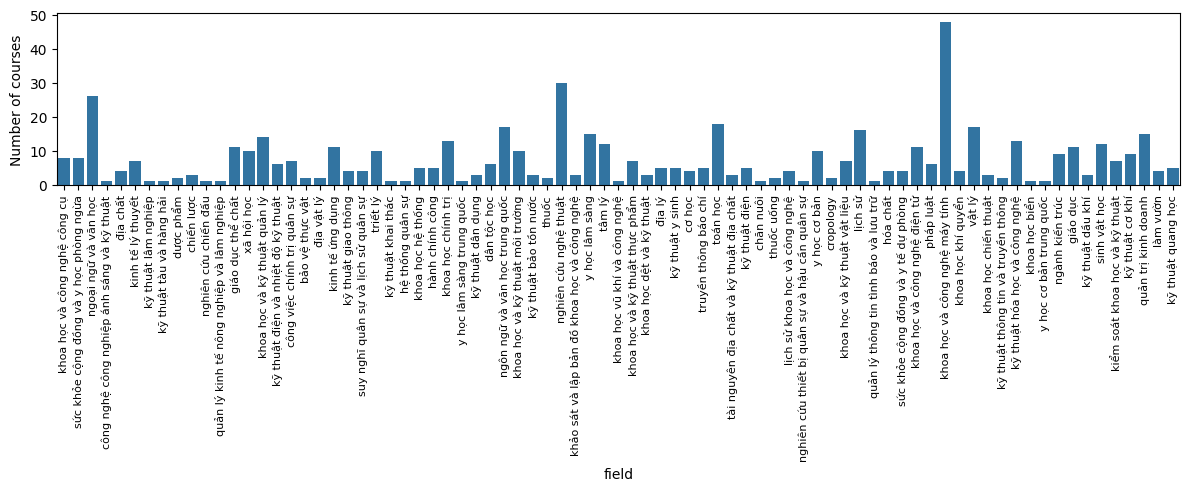

N fields: 79


In [ ]:
exploded_df = courses_df.select(explode(col("field")).alias("field")).dropna()
field_counts_df = exploded_df.groupBy("field").count()

field_counts_pd = field_counts_df.toPandas()
plt.figure(figsize=(12, 5))
sns.barplot(data=field_counts_pd, x="field", y="count")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Number of courses')
plt.tight_layout()
plt.show()

print("N fields:", field_counts_pd.shape[0])

## concept_course

In [ ]:
try:
    concept_course = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="concept_course", keyspace="BIG_MOOC") \
        .load()
    concept_course.show(5)
    concept_course.printSchema()
    concept_course.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+-----------------------------------+---------+
|                         concept_id|course_id|
+-----------------------------------+---------+
|K_数据的清洗过程_公共卫生与预防医学| C_682012|
|K_数据的清洗过程_公共卫生与预防医学| C_682574|
|          K_房间最大热负荷值_建筑学| C_735321|
|            K_大海航行靠舵手_历史学| C_677020|
|                K_领导团队_工商管理| C_696954|
+-----------------------------------+---------+
only showing top 5 rows

root
 |-- concept_id: string (nullable = false)
 |-- course_id: string (nullable = true)

+-------+---------------------------+---------+
|summary|                 concept_id|course_id|
+-------+---------------------------+---------+
|  count|                     451078|   451078|
|   mean|                       NULL|     NULL|
| stddev|                       NULL|     NULL|
|    min|      K_$ _计算机科学与技术|C_1169394|
|    max|K_ｇ分布的概率分布函数_数学| C_947773|
+-------+---------------------------+---------+



In [ ]:
concept_course_filter = concept_course.dropna().dropDuplicates() \
    .join(courses_df.select("course_id").distinct(), on="course_id", how="inner")

concept_course_filter.show(5)
concept_course_filter.describe().show()

+---------+-------------------------------------+
|course_id|                           concept_id|
+---------+-------------------------------------+
| C_883345|K_希尔排序的执行过程_计算机科学与技术|
| C_697025|                K_融合溃烂_临床中医学|
| C_680879|                            K_天_哲学|
| C_696877|                K_发射能量单元_物理学|
| C_837690|      K_互补型场效应管_电子科学与技术|
+---------+-------------------------------------+
only showing top 5 rows

+-------+---------+---------------------------+
|summary|course_id|                 concept_id|
+-------+---------+---------------------------+
|  count|   350498|                     350498|
|   mean|     NULL|                       NULL|
| stddev|     NULL|                       NULL|
|    min|C_1410156|      K_$ _计算机科学与技术|
|    max| C_947773|K_ｇ分布的概率分布函数_数学|
+-------+---------+---------------------------+



In [ ]:
concept_course_filter.select(
    count("*").alias("total_rows"),
    countDistinct("course_id").alias("unique_courses"),
    countDistinct("concept_id").alias("unique_concept")
).show()

+----------+--------------+--------------+
|total_rows|unique_courses|unique_concept|
+----------+--------------+--------------+
|    350498|           719|        214280|
+----------+--------------+--------------+



In [ ]:
save_df_as_text(concept_course_filter, PRE_DIR, "concept_course_filter.txt")

File saved as /content/drive/MyDrive/BigData/Data/concept_course_filter.txt


### Thống kê

In [ ]:
count_course_concept = concept_course_filter.groupBy("course_id") \
    .agg(count("*").alias("count_concept")) \
    .orderBy("count_concept", ascending=False)
count_course_concept.show(10)

+---------+-------------+
|course_id|count_concept|
+---------+-------------+
| C_685689|         3515|
| C_696855|         2091|
| C_707083|         2051|
| C_682610|         2046|
|C_1742805|         1996|
| C_696687|         1972|
| C_854866|         1942|
| C_697091|         1909|
| C_707038|         1859|
| C_680812|         1785|
+---------+-------------+
only showing top 10 rows



Text(0, 0.5, 'Frequency')

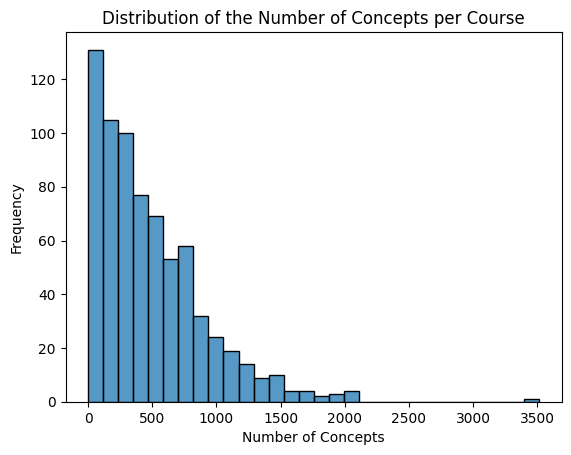

In [ ]:
count_course_concept_pd = count_course_concept.toPandas()
sns.histplot(count_course_concept_pd, x='count_concept')
plt.title('Distribution of the Number of Concepts per Course')
plt.xlabel('Number of Concepts')
plt.ylabel('Frequency')

In [ ]:
count_concept_course = concept_course_filter.groupBy("concept_id") \
    .agg(count("*").alias("count_course")) \
    .orderBy("count_course", ascending=False)
count_concept_course.show(10)

+-----------------------+------------+
|             concept_id|count_course|
+-----------------------+------------+
|  K_类_计算机科学与技术|          84|
|K_方法_计算机科学与技术|          84|
|  K_步_计算机科学与技术|          84|
|  K_根_计算机科学与技术|          84|
|  K_行_计算机科学与技术|          84|
|  K_格_计算机科学与技术|          83|
|  K_区_计算机科学与技术|          83|
|  K_位_计算机科学与技术|          83|
|  K_写_计算机科学与技术|          83|
|  K_图_计算机科学与技术|          82|
+-----------------------+------------+
only showing top 10 rows



In [ ]:
count_concept_course.describe().show()

+-------+---------------------------+------------------+
|summary|                 concept_id|      count_course|
+-------+---------------------------+------------------+
|  count|                     214280|            214280|
|   mean|                       NULL|1.6357009520253873|
| stddev|                       NULL| 2.195463983905295|
|    min|      K_$ _计算机科学与技术|                 1|
|    max|K_ｇ分布的概率分布函数_数学|                84|
+-------+---------------------------+------------------+



## course-school

### Schools

In [ ]:
try:
    school_df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="schools", keyspace="BIG_MOOC") \
        .load()
    school_df.show(5)
    school_df.printSchema()
    school_df.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+---------+-------------------------------------+----------------------+--------------------+--------------------+---------+
|school_id|                                about|                 motto|                name|             name_en|     sign|
+---------+-------------------------------------+----------------------+--------------------+--------------------+---------+
|     S_24| 复旦大学校名取自《尚书大传》之“日...|博学而笃志，切问而近思|            复旦大学|    Fudan University|      fdu|
|    S_595|        西北农林科技大学（Northwes...|                      |    西北农林科技大学|Northwest A&F Uni...|   NWSUAF|
|    S_910|奇安信集团是专门为政府、企业，教育...|                      |          奇安信集团|     Qi An Xin Group|Qi An Xin|
|     S_38|          中国农业大学（China Agri...|                      |        中国农业大学|China Agricultura...|      cau|
|    S_329|      湖北三峡职业技术学院（Hubei ...|      正则，修能，追远|湖北三峡职业技术学院|HuBei Three Gorge...|      tgc|
+---------+-------------------------------------+----------------------+--------------------+-------------------

In [ ]:
check_na(school_df).show()

+---------+-----+-----+----+-------+----+
|school_id|about|motto|name|name_en|sign|
+---------+-----+-----+----+-------+----+
|        0|    0|  282|   0|      0|   0|
+---------+-----+-----+----+-------+----+



### course_school

In [ ]:
try:
    course_school = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="course_school", keyspace="BIG_MOOC") \
        .load()
    course_school.show(5)
    course_school.printSchema()
    course_school.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+---------+---------+
|course_id|school_id|
+---------+---------+
|C_1764861|    S_157|
| C_956450|    S_247|
| C_681996|    S_251|
|C_1992940|    S_486|
|C_2221588|     S_76|
+---------+---------+
only showing top 5 rows

root
 |-- course_id: string (nullable = false)
 |-- school_id: string (nullable = true)

+-------+---------+---------+
|summary|course_id|school_id|
+-------+---------+---------+
|  count|     3983|     3983|
|   mean|     NULL|     NULL|
| stddev|     NULL|     NULL|
|    min|C_1017355|      S_1|
|    max| C_956450|     S_99|
+-------+---------+---------+



In [ ]:
course_school_filter = course_school.dropna().dropDuplicates() \
    .join(courses_df.select("course_id").distinct(), on="course_id", how="inner") \
    .join(school_df.select("school_id").distinct(), on="school_id", how="inner")

course_school_filter.show(5)
course_school_filter.describe().show()

+---------+---------+
|school_id|course_id|
+---------+---------+
|    S_388|C_1992950|
|     S_21| C_680870|
|     S_21| C_682550|
|    S_388|C_2244921|
|    S_316| C_707369|
+---------+---------+
only showing top 5 rows

+-------+---------+---------+
|summary|school_id|course_id|
+-------+---------+---------+
|  count|     2816|     2816|
|   mean|     NULL|     NULL|
| stddev|     NULL|     NULL|
|    min|      S_1|C_1017355|
|    max|     S_99| C_956130|
+-------+---------+---------+



In [ ]:
course_school_filter.select(
    count("*").alias("total_rows"),
    countDistinct("course_id").alias("unique_courses"),
    countDistinct("school_id").alias("unique_school")
).show()

+----------+--------------+-------------+
|total_rows|unique_courses|unique_school|
+----------+--------------+-------------+
|      2816|          2794|          407|
+----------+--------------+-------------+



Lưu file course_school_filter

In [ ]:
save_df_as_text(course_school_filter, PRE_DIR, "course_school_filter.txt")

File saved as /content/drive/MyDrive/BigData/Data/course_school_filter.txt


### Thống kê

Số khoá học thuộc mỗi school

In [ ]:
from pyspark.sql.functions import count

count_school_course = course_school_filter.groupBy("school_id") \
    .agg(count("*").alias("count_course")) \
    .orderBy("count_course", ascending=False)
count_school_course.show(10)

+---------+------------+
|school_id|count_course|
+---------+------------+
|      S_1|         393|
|     S_63|         143|
|     S_31|          92|
|      S_7|          53|
|     S_11|          47|
|      S_9|          46|
|     S_39|          39|
|    S_144|          38|
|    S_148|          37|
|    S_107|          37|
+---------+------------+
only showing top 10 rows



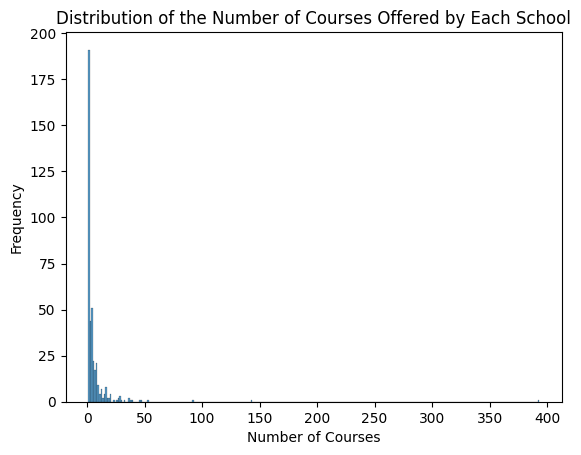

In [ ]:
count_school_course_pd = count_school_course.toPandas()
sns.histplot(count_school_course_pd, x='count_course')
plt.title('Distribution of the Number of Courses Offered by Each School')
plt.xlabel('Number of Courses')
plt.ylabel('Frequency')
plt.show()

Số school của mỗi khoá học

In [ ]:
count_course_school = course_school_filter.groupBy("course_id") \
    .agg(count("*").alias("count_school")) \
    .orderBy("count_school", ascending=False).show(5)

+---------+------------+
|course_id|count_school|
+---------+------------+
| C_682551|           2|
| C_697301|           2|
| C_696721|           2|
| C_677218|           2|
| C_707173|           2|
+---------+------------+
only showing top 5 rows



## course_teacher

### teacher

In [ ]:
try:
    teacher_df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="teachers", keyspace="BIG_MOOC") \
        .load()
    teacher_df.show(5)
    teacher_df.printSchema()
    teacher_df.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+----------+-------------------------------------+---------+------+-----------+------------------------+
|teacher_id|                                about|job_title|  name|    name_en|                org_name|
+----------+-------------------------------------+---------+------+-----------+------------------------+
|    T_5639|    武欢欢，2018年西安邮电大学硕士...|     助教|武欢欢|       NULL|陕西国防工业职业技术学院|
|    T_7952|前国家队花样滑冰双人滑运动员，曾获...|         |陈晓雪|       NULL|                清华大学|
|   T_16307|                                     |         |薛静锋|           |            北京理工大学|
|    T_5193|专注软件技术职业教育，具有多年软件...|   副教授|张暑军|       NULL|                学堂在线|
|    T_2946|   研究领域： 英语教学  论文与著作...|     教授|肖友群|Xiao Youqun|            江西农业大学|
+----------+-------------------------------------+---------+------+-----------+------------------------+
only showing top 5 rows

root
 |-- teacher_id: string (nullable = false)
 |-- about: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- name: string (

In [ ]:
check_na(teacher_df).show()

+----------+-----+---------+----+-------+--------+
|teacher_id|about|job_title|name|name_en|org_name|
+----------+-----+---------+----+-------+--------+
|         0| 3125|     2250|   0|  11635|       0|
+----------+-----+---------+----+-------+--------+



### course_teacher

In [ ]:
try:
    course_teacher = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="course_teacher", keyspace="BIG_MOOC") \
        .load()
    course_teacher.show(5)
    course_teacher.printSchema()
    course_teacher.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+---------+----------+
|course_id|teacher_id|
+---------+----------+
| C_682336|    T_3321|
|C_1814140|   T_11538|
|C_1814140|   T_11541|
|C_1814140|   T_11542|
|C_1814140|   T_11543|
+---------+----------+
only showing top 5 rows

root
 |-- course_id: string (nullable = false)
 |-- teacher_id: string (nullable = true)

+-------+---------+----------+
|summary|course_id|teacher_id|
+-------+---------+----------+
|  count|    46006|     46006|
|   mean|     NULL|      NULL|
| stddev|     NULL|      NULL|
|    min|C_1001635|       T_1|
|    max| C_999405|    T_9999|
+-------+---------+----------+



In [ ]:
course_teacher_filter = course_teacher.dropna().dropDuplicates() \
              .join(courses_df.select("course_id").distinct(), on="course_id", how="inner") \
              .join(teacher_df.select("teacher_id").distinct(), on="teacher_id", how="inner")

course_teacher_filter.show(5)
course_teacher_filter.describe().show()

+----------+---------+
|teacher_id|course_id|
+----------+---------+
|   T_10956|C_1789688|
|    T_5680| C_879074|
|    T_8811|C_1811720|
|    T_8571|C_1410145|
|    T_2423| C_681592|
+----------+---------+
only showing top 5 rows

+-------+----------+---------+
|summary|teacher_id|course_id|
+-------+----------+---------+
|  count|     10658|    10658|
|   mean|      NULL|     NULL|
| stddev|      NULL|     NULL|
|    min|       T_1|C_1017355|
|    max|    T_9999| C_956130|
+-------+----------+---------+



In [ ]:
course_teacher_filter.select(
    count("*").alias("total_rows"),
    countDistinct("course_id").alias("unique_courses"),
    countDistinct("teacher_id").alias("unique_teacher")
).show()

+----------+--------------+--------------+
|total_rows|unique_courses|unique_teacher|
+----------+--------------+--------------+
|     10658|          2828|          8957|
+----------+--------------+--------------+



Lưu file course_teacher_filter

In [ ]:
save_df_as_text(course_teacher_filter, PRE_DIR, "course_teacher_filter.txt")

File saved as /content/drive/MyDrive/BigData/Data/course_teacher_filter.txt


### Thống kê

In [ ]:
count_teacher_course = course_teacher_filter.groupBy("teacher_id") \
    .agg(count("*").alias("count_course")) \
    .orderBy("count_course", ascending=False)
count_teacher_course.show(10)

+----------+------------+
|teacher_id|count_course|
+----------+------------+
|     T_765|          15|
|    T_1908|          11|
|     T_805|          11|
|    T_1484|          10|
|     T_402|          10|
|      T_49|           9|
|     T_796|           8|
|     T_540|           8|
|      T_28|           8|
|     T_172|           8|
+----------+------------+
only showing top 10 rows



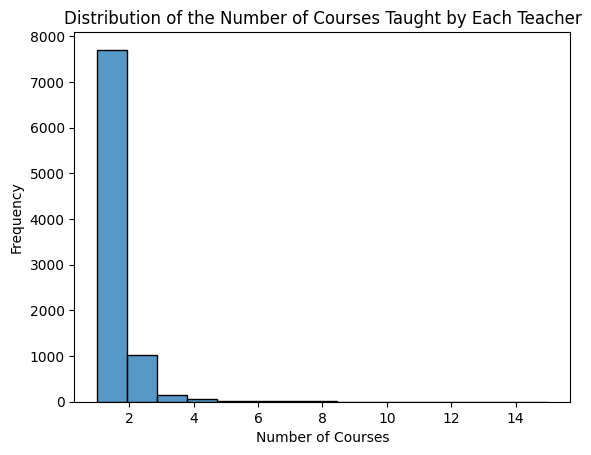

In [ ]:
count_teacher_course_pd = count_teacher_course.toPandas()
sns.histplot(count_teacher_course_pd, x='count_course')
plt.title('Distribution of the Number of Courses Taught by Each Teacher')
plt.xlabel('Number of Courses')
plt.ylabel('Frequency')
plt.show()

In [ ]:
count_course_teacher = course_teacher_filter.groupBy("course_id") \
    .agg(count("*").alias("count_teacher")) \
    .orderBy("count_teacher", ascending=False)
count_course_teacher.show(10)

+---------+-------------+
|course_id|count_teacher|
+---------+-------------+
| C_769301|           49|
|C_1904668|           44|
|C_1924175|           44|
|C_1683594|           38|
|C_1766167|           37|
| C_681031|           36|
| C_881112|           34|
| C_854832|           24|
|C_1738993|           24|
|C_1925910|           23|
+---------+-------------+
only showing top 10 rows



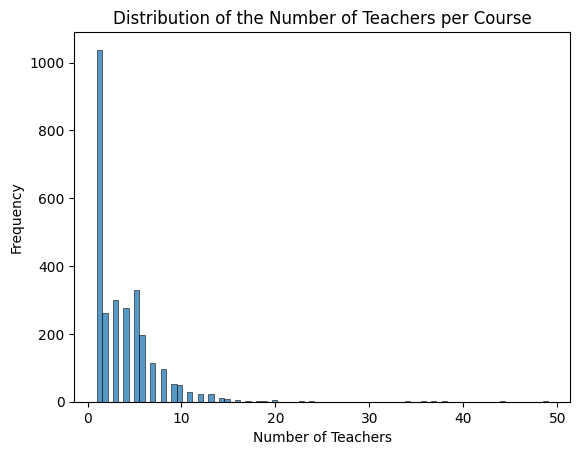

In [ ]:
count_course_teacher_pd = count_course_teacher.toPandas()
sns.histplot(count_course_teacher_pd, x='count_teacher')
plt.title('Distribution of the Number of Teachers per Course')
plt.xlabel('Number of Teachers')
plt.ylabel('Frequency')
plt.show()

## course-topic


In [ ]:
import os
course_topic = spark.read.option("delimiter", "\t") \
                              .csv(os.path.join(PRE_DIR, 'course_topic.txt')) \
                              .toDF("course", "topic")

course_topic.show(5)
course_topic.describe().show()

+---------+-----+
|   course|topic|
+---------+-----+
| C_949439|    9|
|C_1918552|    9|
| C_948270|    7|
| C_682483|   69|
| C_682356|   85|
+---------+-----+
only showing top 5 rows

+-------+---------+------------------+
|summary|   course|             topic|
+-------+---------+------------------+
|  count|     2828|              2828|
|   mean|     NULL|56.716760961810465|
| stddev|     NULL| 34.75635609764866|
|    min|C_1017355|                 0|
|    max| C_956130|                99|
+-------+---------+------------------+



In [ ]:
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import count, countDistinct

course_topic.select(
    count("*").alias("total_rows"),
    countDistinct("course").alias("unique_courses"),
    countDistinct("topic").alias("unique_topic")
).show()

+----------+--------------+------------+
|total_rows|unique_courses|unique_topic|
+----------+--------------+------------+
|      2828|          2828|         119|
+----------+--------------+------------+



### Thống kê

In [ ]:
count_topic_course = course_topic.groupBy("topic") \
    .agg(count("*").alias("count_course")) \
    .orderBy("count_course", ascending=False)
count_topic_course.show(10)

+-----+------------+
|topic|count_course|
+-----+------------+
|   13|          76|
|   35|          72|
|  115|          62|
|   28|          56|
|   33|          53|
|    4|          51|
|   53|          49|
|   62|          48|
|   39|          46|
|   20|          46|
+-----+------------+
only showing top 10 rows



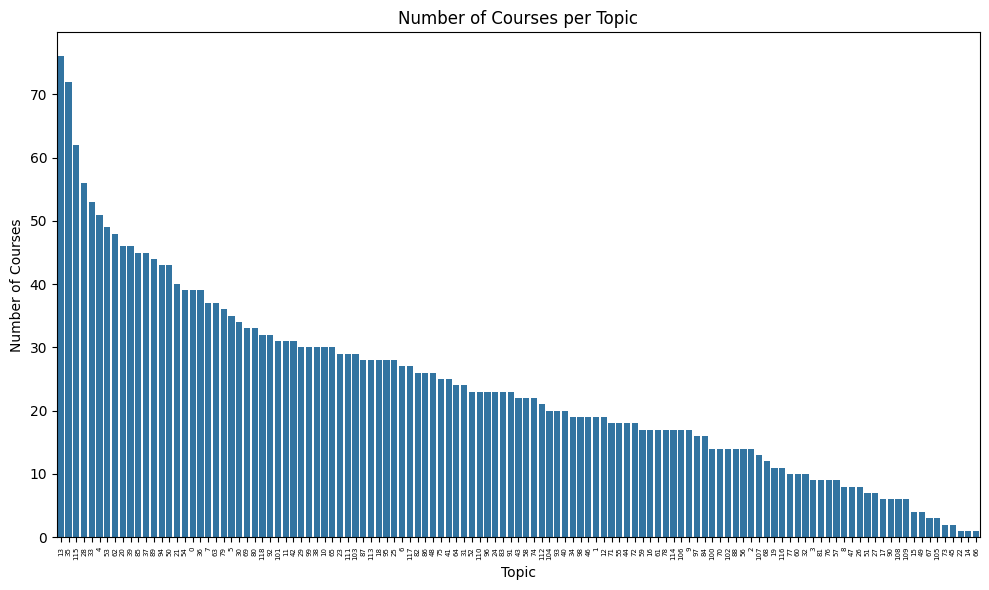

In [ ]:
top_topics_df = count_topic_course.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_topics_df, x="topic", y="count_course")
plt.title("Number of Courses per Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Courses")
plt.xticks(rotation=90, fontsize=5)
plt.tight_layout()
plt.show()

## user_course

### user

In [ ]:
try:
    user_df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="users", keyspace="BIG_MOOC") \
        .load()
    user_df.show(5)
    user_df.printSchema()
    user_df.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+----------+------+-----------------+------------+-------------+
|   user_id|gender|             name|      school|year_of_birth|
+----------+------+-----------------+------------+-------------+
|U_15773538|   2.0|Kiều Thu Thảo Lan|            |             |
|U_32050244|   0.0|      Cao Tấn Tâm|            |             |
|U_31075053|   1.0|  Ngô Tường Giang|            |             |
|U_19230972|   2.0|   Dương Xuân Yến|            |             |
|  U_712095|   0.0|      Đỗ Văn Dũng|新疆师范大学|             |
+----------+------+-----------------+------------+-------------+
only showing top 5 rows

root
 |-- user_id: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- name: string (nullable = true)
 |-- school: string (nullable = true)
 |-- year_of_birth: string (nullable = true)

+-------+---------+------------------+--------------+--------------------+------------------+
|summary|  user_id|            gender|          name|              school|     year_of_birth|
+----

In [ ]:
check_na(user_df).show()

+-------+------+----+------+-------------+
|user_id|gender|name|school|year_of_birth|
+-------+------+----+------+-------------+
|      0|     0|   0| 79031|        99100|
+-------+------+----+------+-------------+



### user_course


In [ ]:
try:
    user_course = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(table="user_course", keyspace="BIG_MOOC") \
        .load()
    user_course.show(5)
    user_course.printSchema()
    user_course.describe().show()
except Exception as e:
    print(f"Lỗi khi kết nối: {str(e)}")

+----------+---------+-------------------+
|   user_id|course_id|        enroll_time|
+----------+---------+-------------------+
|U_28575648| C_696855|2020-07-27 15:52:39|
|U_28575648| C_697791|2020-09-27 18:13:29|
|U_28575648| C_707038|2020-03-11 14:47:58|
|U_28575648| C_735290|2020-11-12 16:47:12|
|U_28575648| C_845950|2020-09-27 18:14:24|
+----------+---------+-------------------+
only showing top 5 rows

root
 |-- user_id: string (nullable = false)
 |-- course_id: string (nullable = true)
 |-- enroll_time: timestamp (nullable = true)

+-------+---------+---------+
|summary|  user_id|course_id|
+-------+---------+---------+
|  count|  1996390|  1996390|
|   mean|     NULL|     NULL|
| stddev|     NULL|     NULL|
|    min|U_1000129|C_1017355|
|    max| U_999500| C_956130|
+-------+---------+---------+



In [ ]:
user_course.select(
    count("*").alias("total_rows"),
    countDistinct("user_id").alias("unique_users"),
    countDistinct("course_id").alias("unique_courses")
).show()

+----------+------------+--------------+
|total_rows|unique_users|unique_courses|
+----------+------------+--------------+
|   1996390|       99970|          2828|
+----------+------------+--------------+



### Thống kê

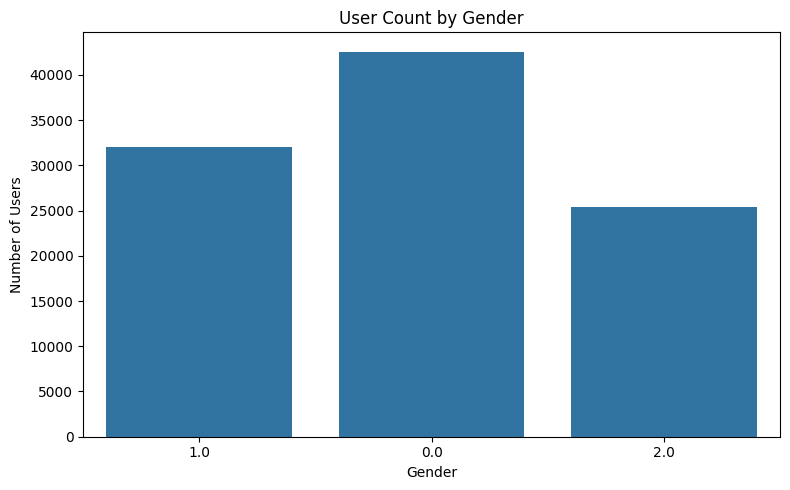

In [ ]:
gender_counts_df = user_df.groupBy("gender").count()
gender_counts_pd = gender_counts_df.toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(data=gender_counts_pd, x='gender', y='count')
plt.title('User Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

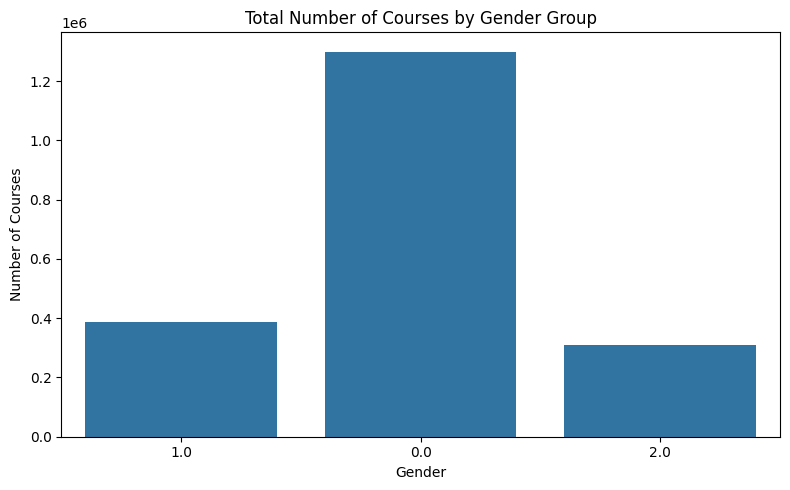

In [ ]:
joined_df = user_course.join(user_df.select("user_id", "gender"), on="user_id", how="inner")
gender_course_count = joined_df.groupBy("gender").count()
gender_course_pd = gender_course_count.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=gender_course_pd, x="gender", y="count")
plt.title("Total Number of Courses by Gender Group")
plt.xlabel("Gender")
plt.ylabel("Number of Courses")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
count_course_user = user_course.groupBy("course_id") \
    .agg(count("*").alias("count_user")) \
    .orderBy("count_user", ascending=False)
count_course_user.show(10)

+---------+----------+
|course_id|count_user|
+---------+----------+
| C_696994|     18379|
| C_676932|     15446|
| C_697791|     14095|
| C_883345|     12970|
| C_629559|     12153|
| C_696700|     10329|
| C_696942|      9330|
| C_697034|      8278|
| C_679390|      7958|
| C_697821|      7779|
+---------+----------+
only showing top 10 rows



In [ ]:
count_course_user.describe().show()

+-------+---------+-----------------+
|summary|course_id|       count_user|
+-------+---------+-----------------+
|  count|     2828|             2828|
|   mean|     NULL|705.9370579915135|
| stddev|     NULL|1313.732642603535|
|    min|C_1017355|                5|
|    max| C_956130|            18379|
+-------+---------+-----------------+



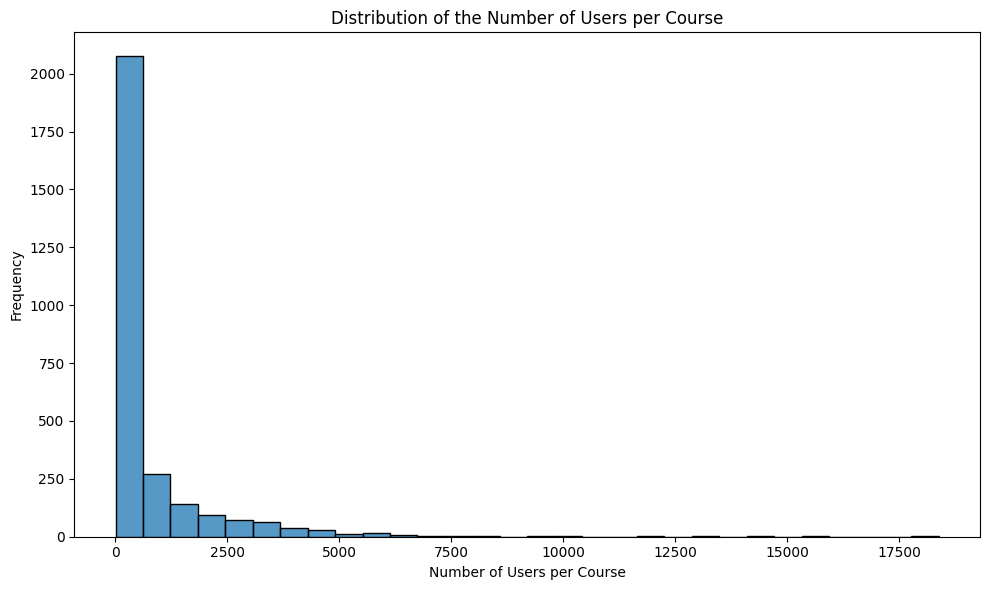

In [ ]:
count_course_user_pd = count_course_user.toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(data=count_course_user_pd, x='count_user', bins=30)
plt.xlabel('Number of Users per Course')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Users per Course')
plt.tight_layout()
plt.show()

In [ ]:
save_df_as_text(user_df, PRE_DIR, "users.txt")

File saved as /content/drive/MyDrive/BigData/Data/users.txt


In [ ]:
save_df_as_text(courses_df, PRE_DIR, "courses.txt")

File saved as /content/drive/MyDrive/BigData/Data/courses.txt
